# Clean data


In [9]:
import mne
from autoreject import AutoReject
from autoreject import get_rejection_threshold
from mne.preprocessing import ICA
import toml
import mne_bids
import re
from pathlib import Path
import autoreject
mne.viz.set_browser_backend('matplotlib')


'matplotlib'

In [10]:
config = toml.load("../../.env.toml")

project_path = config["project"]["path"]
data_path = f"{project_path}/data/raw/BIDS" #Into which directory the data should go
files = [file for file in Path(data_path).glob('**/*.set')]

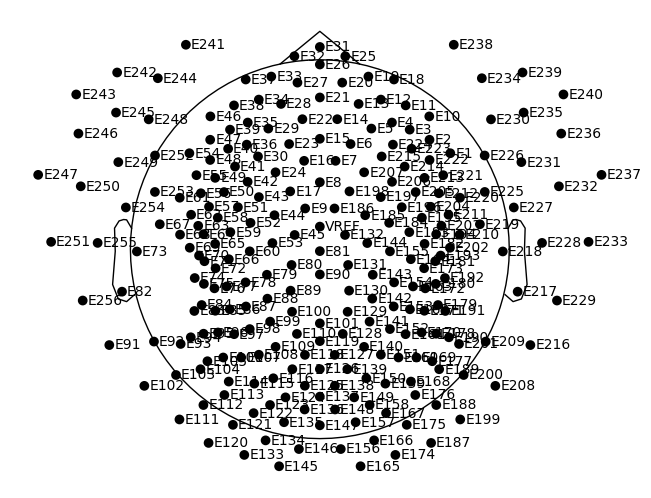

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 833 samples (6.611 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


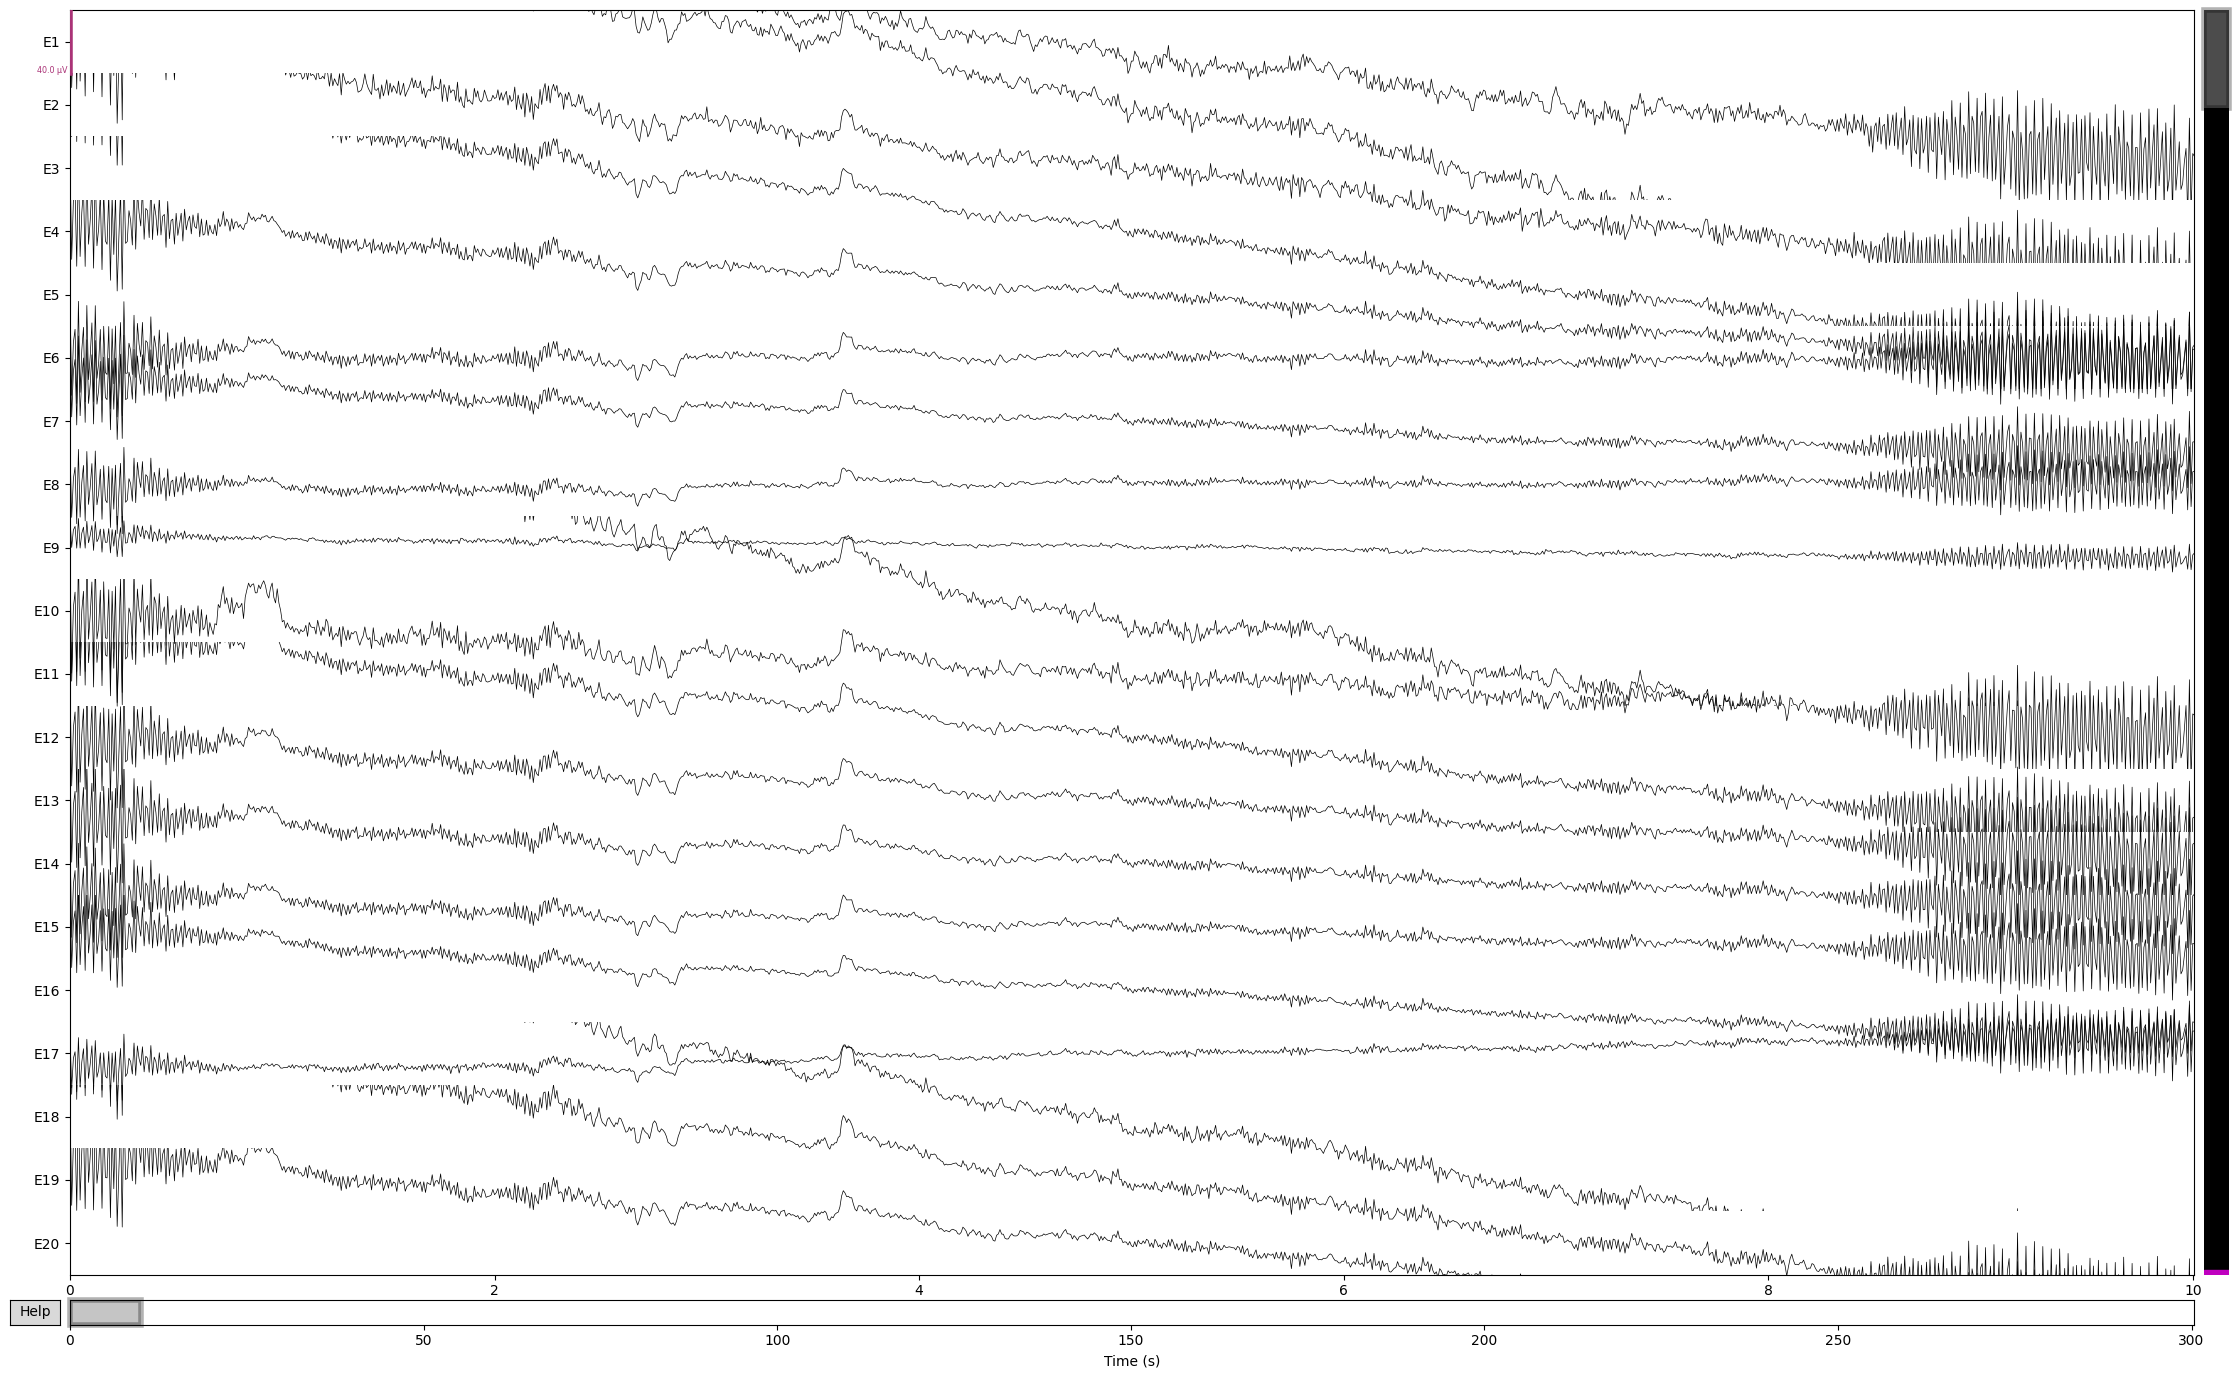

Effective window size : 16.254 (s)


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_6859/1575664961.py:19: UserWarning: Zero value in spectrum for channel VREF
  spectrum = raw_notch.copy().compute_psd()
/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_6859/1575664961.py:20: UserWarning: Infinite value in PSD for channel VREF.
These channels might be dead.
  _ = spectrum.plot(average=True, picks="data", exclude="bads")
/Users/daniel/.pyenv/versions/brainlat-3.12.1/lib/python3.12/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


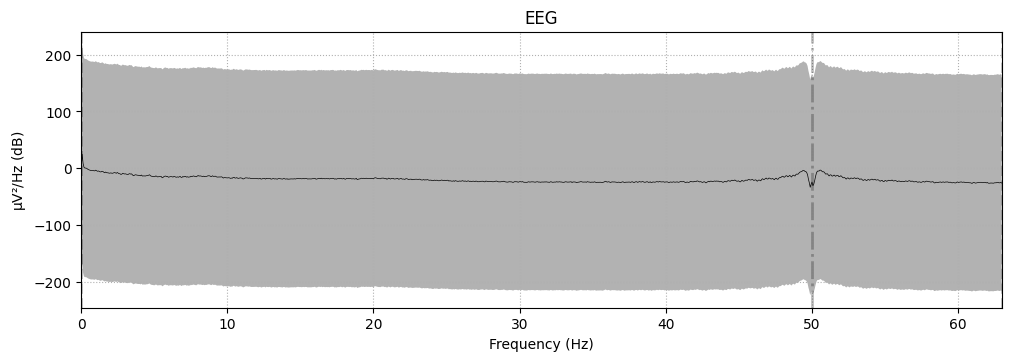

In [11]:
# --- Check types of Channels ---
raw = mne.io.read_raw_eeglab(files[1], preload=True).resample(sfreq=126)
ch_name_type = dict(zip(raw.ch_names, raw.get_channel_types()))

ch_name_ecg = [name for name in raw.ch_names if name in 'ECG']
dict_ecg = {sub[0] : 'ecg' for sub in (ele.split() for ele in ch_name_ecg)}
raw.set_channel_types(dict_ecg)

# documented here https://mne.discourse.group/t/mismatching-between-channel-names-and-types-when-read-raw-eeglab/5811

raw.set_montage('GSN-HydroCel-257', match_alias= {'VREF' :'Cz'})
raw.plot_sensors(show_names=True);
raw.info['line_freq'] = 50.
freqs = (50)
eeg_picks = mne.pick_types(raw.info, eeg=True)

raw_notch = raw.copy().notch_filter(freqs=freqs, picks=eeg_picks)
_ = mne.viz.plot_raw(raw_notch)
spectrum = raw_notch.copy().compute_psd()
_ = spectrum.plot(average=True, picks="data", exclude="bads")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-12 dB cutoff frequency: 47.50 Hz)
- Filter length: 832 samples (6.603 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Effective window size : 16.254 (s)


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_6859/490480742.py:8: UserWarning: Zero value in spectrum for channel VREF
  spectrum = raw_cropped.copy().compute_psd()
/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_6859/490480742.py:9: UserWarning: Infinite value in PSD for channel VREF.
These channels might be dead.
  _ = spectrum.plot(average=True, picks="data", exclude="bads");
/Users/daniel/.pyenv/versions/brainlat-3.12.1/lib/python3.12/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


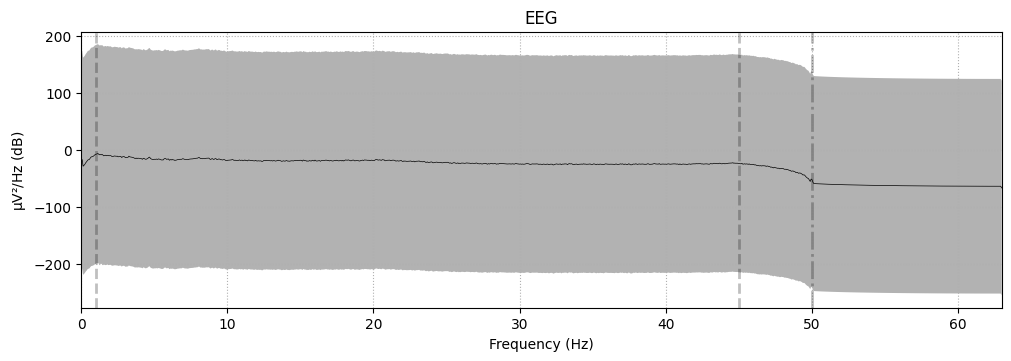

In [12]:
filter_params = {'l_freq': 1,
                 'h_freq': 45,
                 'h_trans_bandwidth': 5,
                 'fir_design': 'firwin2',
                 'phase': 'zero-double'}
raw_cropped =raw.copy().crop(tmin=6, tmax=300, include_tmax=True)
raw_cropped.filter(**filter_params)
spectrum = raw_cropped.copy().compute_psd()
_ = spectrum.plot(average=True, picks="data", exclude="bads");

In [16]:
epochs=mne.make_fixed_length_epochs(raw_notch, duration=1.0, preload=False, proj=True)
reject = get_rejection_threshold(epochs)
print('The rejection dictionary is %s' % reject)
epochs.drop_bad(reject=reject)
epochs.plot_drop_log();

NameError: name 'raw_notch' is not defined

Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 98 events and 379 original time points ...


2 bad epochs dropped
No projector specified for this dataset. Please consider the method self.add_proj.


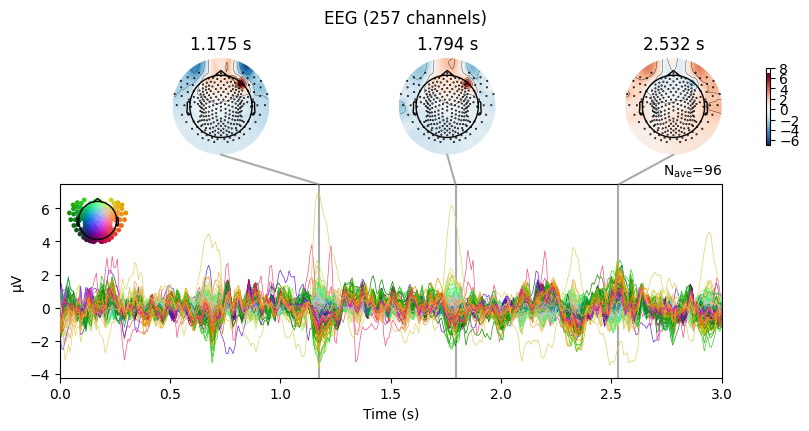

In [15]:
events = mne.make_fixed_length_events(raw        = raw_cropped,
                                      start      = 0,
                                      stop       = None,
                                      duration   = 3,
                                      overlap    = 0,
                                      first_samp = False)

# Create  Epochs object
epochs = mne.Epochs(raw      = raw_cropped,
                    events   = events,
                    tmin     = 0,
                    tmax     = 3,
                    detrend  = 1,
                    baseline = None,
                    preload  = True)
epochs.copy().average().detrend().plot_joint();

Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 0.0003693014014618365}
0 bad epochs dropped


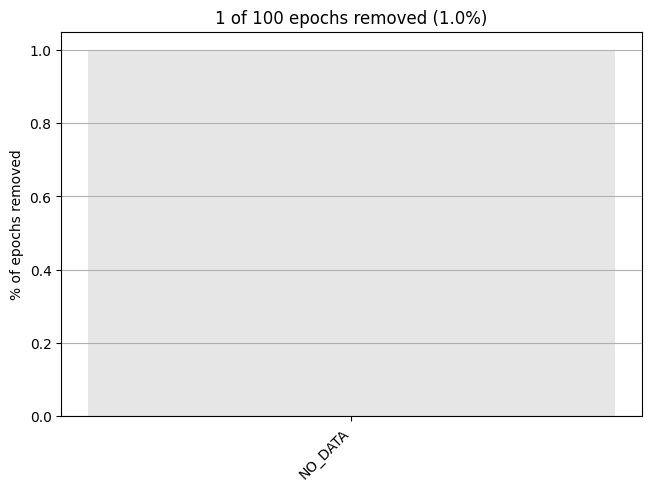

In [11]:
reject = get_rejection_threshold(epochs)
print('The rejection dictionary is %s' % reject)
epochs.drop_bad(reject=reject)
epochs.plot_drop_log();

In [13]:
mne.viz.plot_epochs(epochs, picks='eeg', show=True)

Using qt as 2D backend.
Using pyopengl with version 3.1.7


In [14]:
def run_ica(raw_notch_interp):
    ica = ICA(n_components=20, max_iter="auto", random_state=97)
    ica.fit(raw_notch_interp)
    ica

    explained_var_ratio = ica.get_explained_variance_ratio(raw_notch_interp)
    for channel_type, ratio in explained_var_ratio.items():
        print(
            f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
        )

    explained_var_ratio = ica.get_explained_variance_ratio(
        raw_notch_interp, components=[0], ch_type="eeg"
    )
    # This time, print as percentage.
    ratio_percent = round(100 * explained_var_ratio["eeg"])
    print(
        f"Fraction of variance in EEG signal explained by first component: "
        f"{ratio_percent}%"
    )
    return ica


ica = run_ica(epochs)

Fitting ICA to data using 257 channels (please be patient, this may take a while)


Selecting by number: 20 components


## Steps of analysis

- filter out above 256 Hz (automatically done by mne before resampling)
- Resample to 256 Hz


## Autoreject without any other preprocessing


In [10]:
ar = autoreject.AutoReject(n_interpolate=[1, 2, 3, 4], random_state=11,
                           n_jobs=1, verbose=True)
ar.fit(epochs[:20])  # fit on a few epochs to save time
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

/Users/daniel/.pyenv/versions/brainlat-3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running autoreject on ch_type=eeg


 12%|█▏        | Creating augmented epochs : 32/257 [08:05<56:54,   15.18s/it] 


KeyboardInterrupt: 

In [9]:
epochs[reject_log.bad_epochs].plot(scalings=dict(eeg=100e-6))


: 

In [ ]:
reject_log.plot('horizontal')
